# Bike rental forecasting using Velib data set, 
### Requirements: Python 2.7, matplotlib, Pandas, Pyspark 1.5.0+ (MLlib and ML Packages)

Le forecasting sur les séries temporelles est d'un intérêt considérable et transversal pour tous les métiers (marketing, supervision, sécurité, publicité, etc.). Dans ce notebook python, nous allons mettre en oeuvre une technique d'apprentissage pour prédire la tendance d'une série temporelle.

Ce code ci-dessous est compatible Python 2.x et a des dépendences avec: 
-- matplotlib: pour les graphiques (visualisation de la cross-correlation)
-- pandas: pour la calcul de la cross-corélation et la visualisation des données
-- pyspark: pour la scalabilité i.e. les données et le modèle sont distribués

In [1]:
# Disable warnings, set Matplotlib inline plotting and load Pandas package
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import pandas as pd
pd.options.display.mpl_style = 'default'

### Chargement des données

On suppose que les données sont bien formattées; dans le cas contraire, une phase de filtrage à base d'expressions régulières est nécessaire.
On supposera que le notebook a été exécuté depuis le répertoire: "base_dir = /home/quantmetry", et que le répertoire "base_dir/data/" contient le fichier "data.csv"

Le fichier "data.csv" est divisé en deux parties: 80% des données dans "data_train_80.csv" pour l'entrainement du modèle et les 20% restants dans "data_test_20.csv" pour le test final du modèle.

##### Attention: les deux fichiers "data_train_80.csv" et "data_test_20.csv" doivent avoir la même entête qui se trouve dans "data.csv"

In [2]:
CV_data = sqlContext.read.load('./data/data_train_80.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',
                          delimiter=',',
                          inferSchema='true')

final_test_data = sqlContext.read.load('./data/data_test_20.csv', 
                          format='com.databricks.spark.csv', 
                          header='true', 
                          delimiter=',',
                          inferSchema='true')
CV_data.cache()
final_test_data.cache()

DataFrame[datetime: timestamp, season: int, holiday: int, workingday: int, weather: int, temp: double, atemp: double, humidity: int, windspeed: double, casual: int, registered: int, count: int]

### Résumé des données

Ici, on utilisera les dataframes pandas pour la qualité du rendu à l'affichage 

In [3]:
CV_data.printSchema()

root
 |-- datetime: timestamp (nullable = true)
 |-- season: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weather: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- atemp: double (nullable = true)
 |-- humidity: integer (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- count: integer (nullable = true)



In [4]:
pd.DataFrame(CV_data.take(5), columns=CV_data.columns)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
CV_data.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
season,8886,2.2417285617825793,1.046669640421226,1,4
holiday,8886,0.026896241278415486,0.16178020114806616,0,1
workingday,8886,0.6829844699527347,0.46531353274552073,0,1
weather,8886,1.4098582039162728,0.6366141394975868,1,4
temp,8886,20.28692550078764,8.062583390860647,0.82,41.0
atemp,8886,23.741926626153344,8.777868930656798,0.76,45.455
humidity,8886,61.11973891514742,19.615435656124234,0,100
windspeed,8886,13.020427582714277,8.288122788394093,0.0,56.9969
casual,8886,34.57393652937205,48.381189208656046,0,367


### Features engineering

Nous allons convertir les dates en timestamps (i.e. valeurs entières en secondes), puis supprimer le champs "datetime" qui est donc redondant avec "timestamp" pour notre analyse

In [6]:
from datetime import datetime, timedelta, time
import pytz
from pyspark.sql.types import DoubleType, TimestampType
from pyspark.sql.functions import udf, col


def parse_dt_to_ts(dt):
    #return TimestampType.toInternal(dt)
    return (pytz.utc.localize(dt)-datetime(1970,1,1,tzinfo=pytz.utc)).total_seconds()

parse_dt=udf(parse_dt_to_ts, DoubleType())


def parse_int_to_double(cnt):
    #return TimestampType.toInternal(dt)
    return cnt*1.0

parse_dt=udf(parse_dt_to_ts, DoubleType())
parse_cnt=udf(parse_int_to_double, DoubleType())

CV_data_ts = CV_data.withColumn("ts", parse_dt("datetime")).withColumn("label", parse_cnt("count")).drop("datetime").drop("count")
final_test_data = final_test_data.withColumn("ts", parse_dt("datetime")).withColumn("label", parse_cnt("count")).drop("datetime").drop("count")
pd.DataFrame(CV_data_ts.take(5), columns=CV_data_ts.columns)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,ts,label
0,1,0,0,1,9.84,14.395,81,0.0,3,13,1.293840e+09,16.0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,1.293844e+09,40.0
2,1,0,0,1,9.02,13.635,80,0.0,5,27,1.293847e+09,32.0
3,1,0,0,1,9.84,14.395,75,0.0,3,10,1.293851e+09,13.0
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1.293854e+09,1.0


### Cross-corrélation

Ici, on utilisera les fonctions statistiques des dataframes pandas pour calculer la matrice des nuages de points.

Il est intéressant de savoir que pour des raisons de scalabilité, nous pouvons utiliser les fonctions statistiques des dataframes Spark (ex. "df.stat.corr('column1', 'column2')") pour calculer la matrice de cross-corrélation. 

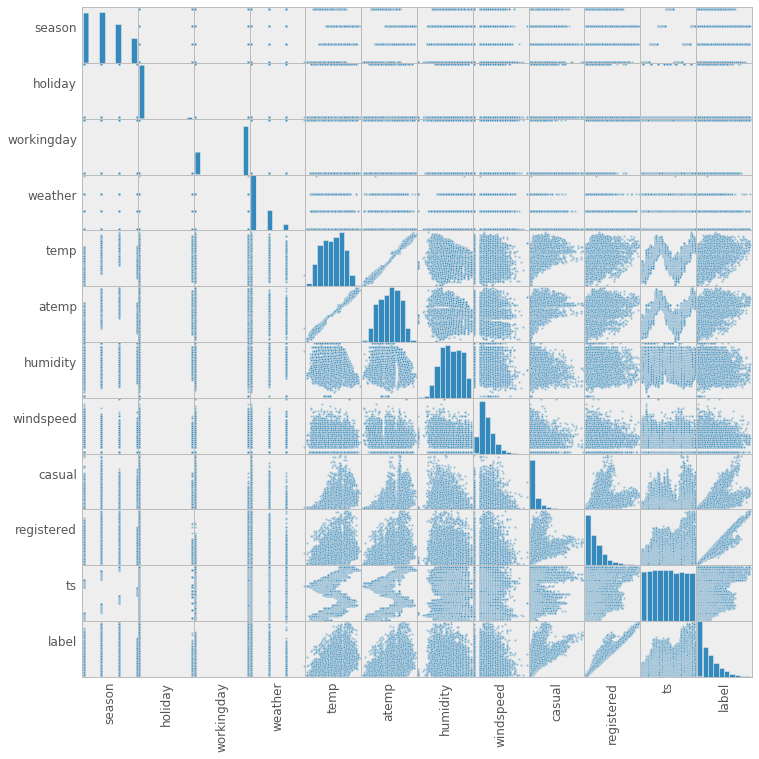

In [7]:
numeric_features = [t[0] for t in CV_data_ts.dtypes if t[1] == 'int' or t[1] == 'double']

#sampled_data = CV_data.select(numeric_features).sample(False, 0.10).toPandas()
sampled_data = CV_data_ts.select(numeric_features).toPandas()

axs = pd.scatter_matrix(sampled_data, figsize=(12, 12));

# Rotate axis labels and remove axis ticks
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

### Suppression d'un facteur linéairement dépendant

Au vue, de la matrice de nuages des points, nous remarquons que les facteurs "temp" et "atemp" sont approximativement dépendants. D'où la suppression du facteur "atemp"

In [8]:
from pyspark.sql.types import DoubleType

CV_data = CV_data_ts.drop('atemp').cache()

final_test_data = final_test_data.drop('atemp').cache()

In [9]:
pd.DataFrame(final_test_data.take(5), columns=final_test_data.columns)

,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,ts,label
0,3,0,0,1,31.16,40,8.9981,235,342,1.344784e+09,577.0
1,3,0,0,1,31.16,40,7.0015,213,300,1.344787e+09,513.0
2,3,0,0,1,32.80,33,0.0000,186,319,1.344791e+09,505.0
3,3,0,0,1,31.98,35,7.0015,164,327,1.344794e+09,491.0
4,3,0,0,1,30.34,40,8.9981,148,317,1.344798e+09,465.0


### Création du modèle d'apprentisage automatique: avec MLlib

Ici, nous ferons notre démonstration à l'aide d'un arbre de décision. Et pour des raisons de scalabilité, nous allons utiliser les packages de MLlib de PySpark

In [11]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree
from pyspark.mllib.evaluation import RegressionMetrics
from math import sqrt

def labelData(data):
    # label: row[end], features: row[0:end-1]
    return data.map(lambda row: LabeledPoint(row[-1], row[:-1]))

training_data, testing_data = labelData(CV_data).randomSplit([0.8, 0.2])

model = DecisionTree.trainRegressor(training_data, categoricalFeaturesInfo={},
                                    impurity='variance', maxDepth=3, maxBins=32)

# Evaluate model on test instances and compute test error
predictions = model.predict(testing_data.map(lambda x: x.features))
labelsAndPredictions = testing_data.map(lambda lp: lp.label).zip(predictions)
testMSE = labelsAndPredictions.map(lambda (v, p): (v - p) * (v - p)).sum() / float(testing_data.count())
print('Test Root Mean Squared Error = ' + str(sqrt(testMSE)))
# Instantiate metrics object
metrics = RegressionMetrics(labelsAndPredictions)

# Squared Error
print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)

# R-squared
print("R-squared = %s" % metrics.r2)

# Mean absolute error
print("MAE = %s" % metrics.meanAbsoluteError)

# Explained variance
print("Explained variance = %s" % metrics.explainedVariance)

print('Learned regression tree model:')
print(model.toDebugString())

Test Root Mean Squared Error = 42.5027935172
MSE = 1806.48745677
RMSE = 42.5027935172
R-squared = 0.926081101055
MAE = 28.3738413483
Explained variance = 26996.0851309
Learned regression tree model:
DecisionTreeModel regressor of depth 3 with 15 nodes
  If (feature 8 <= 189.0)
   If (feature 8 <= 80.0)
    If (feature 8 <= 31.0)
     Predict: 14.098765432098766
    Else (feature 8 > 31.0)
     Predict: 67.00704225352112
   Else (feature 8 > 80.0)
    If (feature 8 <= 139.0)
     Predict: 136.95827123695977
    Else (feature 8 > 139.0)
     Predict: 210.962879640045
  Else (feature 8 > 189.0)
   If (feature 8 <= 337.0)
    If (feature 7 <= 119.0)
     Predict: 291.318093385214
    Else (feature 7 > 119.0)
     Predict: 429.30817610062894
   Else (feature 8 > 337.0)
    If (feature 8 <= 489.0)
     Predict: 474.8507795100223
    Else (feature 8 > 489.0)
     Predict: 674.7633928571429



### Evaluation du modèle sur les données de test (data_test_20.csv)


In [12]:
test_data = labelData(final_test_data)

# Evaluate model on test instances and compute test error
predictions = model.predict(test_data.map(lambda x: x.features))
valuesAndPreds = test_data.map(lambda lp: lp.label).zip(predictions)

# Instantiate metrics object
test_metrics = RegressionMetrics(valuesAndPreds)

# Squared Error
print("MSE = %s" % test_metrics.meanSquaredError)
print("RMSE = %s" % test_metrics.rootMeanSquaredError)

# R-squared
print("R-squared = %s" % test_metrics.r2)

# Mean absolute error
print("MAE = %s" % test_metrics.meanAbsoluteError)

# Explained variance
print("Explained variance = %s" % test_metrics.explainedVariance)




MSE = 3705.87088106
RMSE = 60.87586452
R-squared = 0.90441874186
MAE = 40.2539762317
Explained variance = 47047.7153769


# Amélioration par cross-validation: avec ML

Ici, nous ferons notre démonstration à l'aide d'un arbre de décision. Et pour des raisons de scalabilité, nous allons utiliser les packages de ML de PySpark

### Création du modèle d'apprentisage automatique: avec ML

Ici, nous ferons notre démonstration à l'aide d'un arbre de décision. Et pour des raisons de scalabilité, nous allons utiliser les packages de ML de PySpark

In [13]:
from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

def vectorizeData(data):
    return data.map(lambda r: [r[-1], Vectors.dense(r[:-1])]).toDF(['label','features'])
data = vectorizeData(CV_data)

# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a DecisionTree model.
dt = DecisionTreeRegressor(featuresCol="indexedFeatures")

# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, dt])

# Train model.  This also runs the indexer.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

treeModel = model.stages[1]
# summary only
print(treeModel)


+------------------+-----+--------------------+
|        prediction|label|            features|
+------------------+-----+--------------------+
|10.633495145631068| 13.0|[1.0,0.0,0.0,1.0,...|
| 4.078039927404719|  1.0|[1.0,0.0,0.0,1.0,...|
| 4.078039927404719|  2.0|[1.0,0.0,0.0,1.0,...|
|10.633495145631068| 14.0|[1.0,0.0,0.0,1.0,...|
|29.202072538860104| 56.0|[1.0,0.0,0.0,1.0,...|
+------------------+-----+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 24.4095
DecisionTreeRegressionModel of depth 5 with 63 nodes


### Construction du modèle à l'aide de la cross-validation: avec ML

Ici, nous allons automatiser le choix des paramètres du modèles

In [14]:
from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def vectorizeData(data):
    return data.map(lambda r: [r[-1], Vectors.dense(r[:-1])]).toDF(['label','features'])

vectorized_CV_data = vectorizeData(CV_data)


# Automatically identify categorical features and index them
featureIndexer = VectorIndexer(inputCol='features',
                               outputCol='indexedFeatures',
                               maxCategories=2).fit(vectorized_CV_data)

# Train a DecisionTree model
dTree = DecisionTreeRegressor(featuresCol='indexedFeatures')

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, dTree])

# Search through decision tree's maxDepth parameter for best model
paramGrid = ParamGridBuilder().addGrid(dTree.maxDepth, [2,3,4,5,6,7]).build()

# Set F-1 score as evaluation metric for best model selection
##evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')    
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
# Set up 3-fold cross validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

CV_model = crossval.fit(vectorized_CV_data)

# Fetch best model
tree_model = CV_model.bestModel.stages[1]
print tree_model

DecisionTreeRegressionModel of depth 7 with 255 nodes


In [15]:
vectorized_test_data = vectorizeData(final_test_data)

transformed_data = CV_model.transform(vectorized_test_data)
print evaluator.getMetricName(), 'value:', evaluator.evaluate(transformed_data)

predictions = transformed_data.select('label', 'prediction')
predictions.toPandas().head()


rmse value: 34.8859718907


,label,prediction
0,577.0,591.081081
1,513.0,522.400000
2,505.0,561.307692
3,491.0,473.454545
4,465.0,473.454545


In [16]:
print 'done!'

done!
